<table>
    <tr>
      <td>Minería de datos y paradigma BigData - Facultad de Informática - UCM
      </td>
      <td>
      <img src="https://biblioteca.ucm.es/data/cont/media/www/pag-88746//escudo.jpg"  width=50/>
      </td>
     </tr>
</table>



## Práctica 4 - Preprocesamiento de datos: análisis de tuits

Material original de Rafael Caballero, modificada y extendida por Pablo C. Cañizares

---
## Introduccion

En esta practica trabajamos con el dataset **TUSA 2020** (tuits) para recorrer un flujo completo de adquisicion y preparacion de datos con `pandas`: carga desde un CSV comprimido, tipado correcto (fechas e identificadores), analisis visual y cuantitativo de valores faltantes, particion del conjunto en retweets vs tuits originales, limpieza guiada por criterio (columnas inutiles, constantes o especificas de un subconjunto) y un primer feature engineering (longitud del tuit) para detectar y filtrar outliers. El objetivo es aprender a leer el dataset con lupa: entender que significa cada campo, cuando aparece y como condiciona el preprocesado.

### Analisis del dataset
| Campo | Tipo recomendado | Que representa |
|---|---|---|
| `_id` | `str` | Identificador unico del tuit |
| `text` | `str` | Texto del tuit |
| `userid` | `str` | Identificador del usuario |
| `screen_name` | `str` | Nombre de usuario en Twitter |
| `created_at` | `datetime64[ns]` | Fecha/hora de publicacion |
| `lang` | `category` o `str` | Idioma detectado del tuit |
| `quote_count` | `int` | Numero de citas del tuit |
| `reply_count` | `int` | Numero de respuestas |
| `retweet_count` | `int` | Numero de retuits |
| `favorite_count` | `int` | Numero de "me gusta" |
| `coordinates` | `object` | Coordenadas geograficas |
| `reply` | `bool` | Indica si es respuesta |
| `quote` | `bool` | Indica si es cita |
| `RT` | `bool` | Indica si es retweet |
| `RT_source` | `str` | Id del tuit original (si es RT) |
| `nRTin` | `int` | Numero de retweets del tuit incluidos en el dataset |
| `textlen` | `int` | Longitud del texto del tuit |

---
Antes de empezar. Ejecutar el siguiente código para instalar la biblioteca `missingno`. Tras hacerlo conviene reiniciar el entorno Jupyter

In [1]:
modules = ["missingno","matplotlib"]


import sys
import os.path
from subprocess import check_call
import importlib
import os

def instala(modules):
    print("Instalando módulos")
    for m in modules:
        torch_loader = importlib.util.find_spec(m)
        if torch_loader is not None:
              print(m," encontrado")
        else:
            print(m," No encontrado, instalando...",end="")  
            try:        
                r = check_call([sys.executable, "-m", "pip", "install", "--user", m])
                print("¡hecho!")
            except:
                print("¡Problema al instalar ",m,"! ¿seguro que el módulo existe?",sep="")

    print("¡Terminado, quizás haya que hacer Restart!")

instala(modules)  

Instalando módulos
missingno  encontrado
matplotlib  encontrado
¡Terminado, quizás haya que hacer Restart!


---
### **Ejercicio 1**. Leer en un dataframe `df` el fichero csv alojado en una web externa

"https://github.com/RafaelCaballero/tdm/raw/master/datos/tusa2020bcsv.zip"

Teniendo en cuenta que:
1.- Para cargarlo, debes utilizar `pd.read_csv` con la url proporcionada. Ojo, que el ejercicio no termina aquí, tienes que tener en cuenta los dos siguientes puntos.

2.- La columna `created_at` debe ser leída como una fecha. 

3.- Las columnas `_id`,`userid`, `RT_source` deben ser leídas como un string.


Notas: En [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html):
* La opción `parse_dates`  permite leer fechas. Ej: `parse_dates=[column_name]`
* La opción `dtype`  nos permitirá indicar que `_id`,`userid`, `RT_source` son de tipo `str`. Ej: `dtype={column_name:str}`

In [2]:
#solución
import pandas as pd

url="https://github.com/RafaelCaballero/tdm/raw/master/datos/tusa2020bcsv.zip"

df = pd.read_csv(url,dtype={'_id' : str,'userid' : str,'RT_source' : str}, parse_dates=['created_at'])


# para probar
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 8223 entries, 0 to 8222
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   _id             8223 non-null   str                
 1   text            4126 non-null   str                
 2   userid          8223 non-null   str                
 3   screen_name     8223 non-null   str                
 4   created_at      8223 non-null   datetime64[us, UTC]
 5   lang            4126 non-null   str                
 6   quote_count     4126 non-null   float64            
 7   reply_count     4126 non-null   float64            
 8   retweet_count   4126 non-null   float64            
 9   favorite_count  4126 non-null   float64            
 10  coordinates     0 non-null      float64            
 11  reply           4126 non-null   object             
 12  quote           4110 non-null   object             
 13  RT              8223 non-null   bool        

In [3]:
# para probar
df.head()

,_id,text,userid,screen_name,created_at,lang,quote_count,reply_count,retweet_count,favorite_count,coordinates,reply,quote,RT,RT_source,nRTin
0,1322162444786126848,Winners attract other winners,289706821,thatguy0603,2020-10-30 13:04:26+00:00,en,0.0,0.0,0.0,0.0,NaN,False,True,False,NaN,0.0
1,1316829358686834688,NOW WE KNOW...C-SPAN Steve Sculley tried to ri...,1116507977828175872,FloridaDude297,2020-10-15 19:52:39+00:00,en,12.0,28.0,681.0,1232.0,NaN,False,False,False,NaN,0.0
2,1318888111699599362,NaN,1290009888580657152,why_inn,2020-10-21 12:13:24+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1318884437258571777,NaN
3,1321483993922023424,@realDonaldTrump Vote Biden🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊,922851359594033152,Janet06969062,2020-10-28 16:08:30+00:00,fr,0.0,0.0,0.0,0.0,NaN,True,False,False,NaN,0.0
4,1313626566694404096,NaN,3285934814,Bill4TruthTrump,2020-10-06 23:45:54+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1313617592125448194,NaN


Metadatos: 

    _id: identificador del tweet, es único
    text: texto del tweet
    userid: identificador del usuario, se puede repetir porque el mismo usuario puede tener varios tweets           
    screen_name: nombre en twitter del usuario
    created_at: fecha de emisión del tweet
    lang: idioma del tweet
    quote_count, reply_count, retweet_count, favorite_count: número de citas, respuestas, retweets y marcas como favorito de este tweet, respectivamente
    coordinates: coordenadas desde las que se emitió
    reply: True si el tweet es un reply, False en otro caso
    quote: True si el tweet es una cita, False en otro caso
    RT: True si el tweet es un retweet, False en otro caso
    RT_source: Si RT==True  indica el `_id` del tweet original             
    nRTin: número de retweets del tweet incluídos en este conjunto

---
### **Ejercicio 2** 

a) A partir de `df.info()` seleccionar una columna candidata para ser borrada y borrarla. El resultado debe quedar en un dataframe `df2`
PD: No debéis seleccionarla de manera programática, únicamente analizar el resultado de `df.info()` y utilizar ese cerebrazo que tenéis.

In [4]:
#solución
df2 = df.drop(columns = ['coordinates'])
# para probar
df2.info()

<class 'pandas.DataFrame'>
RangeIndex: 8223 entries, 0 to 8222
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   _id             8223 non-null   str                
 1   text            4126 non-null   str                
 2   userid          8223 non-null   str                
 3   screen_name     8223 non-null   str                
 4   created_at      8223 non-null   datetime64[us, UTC]
 5   lang            4126 non-null   str                
 6   quote_count     4126 non-null   float64            
 7   reply_count     4126 non-null   float64            
 8   retweet_count   4126 non-null   float64            
 9   favorite_count  4126 non-null   float64            
 10  reply           4126 non-null   object             
 11  quote           4110 non-null   object             
 12  RT              8223 non-null   bool               
 13  RT_source       4097 non-null   str         

b) Utilizar la biblioteca `missingno` para mostrar gráficamente la matriz de nulos (método matrix) en `df2`

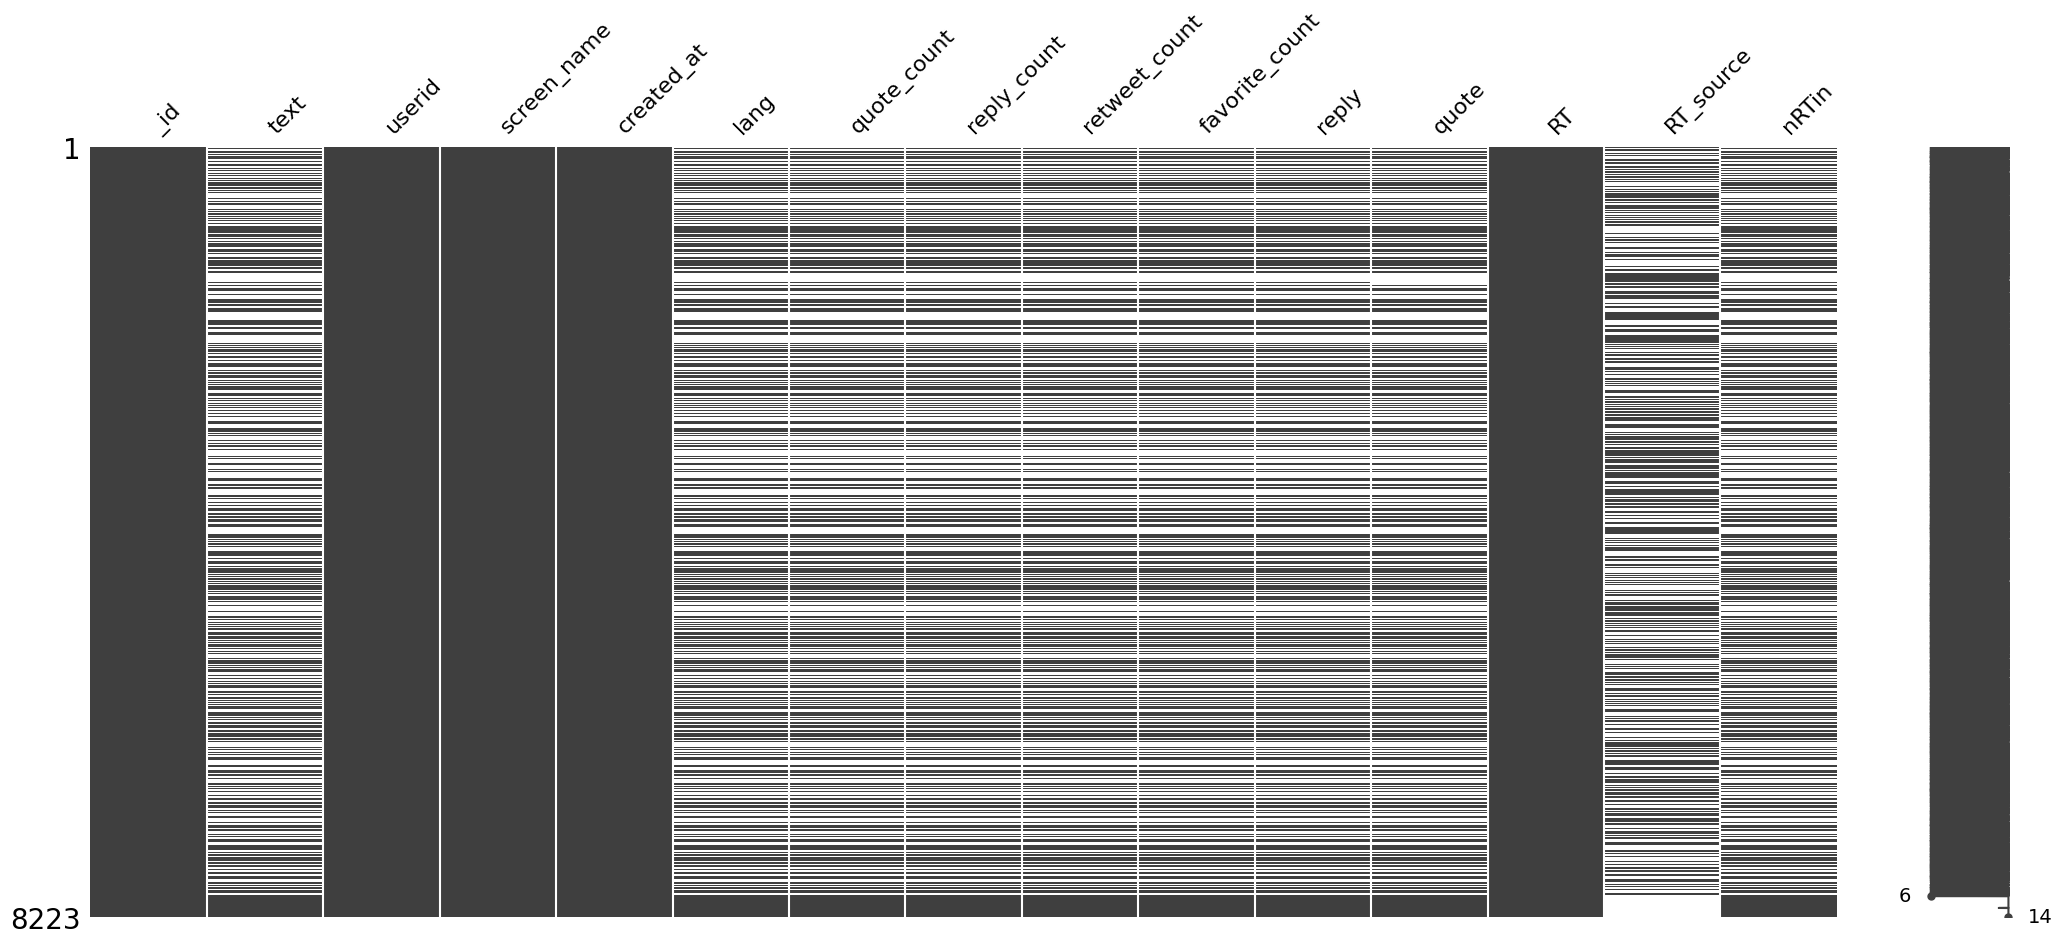

In [5]:
import matplotlib.pyplot as plt
import missingno as msno
df2.isna().sum()
# solución
msno.matrix(df2)
plt.show()

¿Extraes alguna conclusión  a partir de la matriz? (no hace falta que sea una certeza, solo escribir si algo nos llama la atención). Una o 2 frases deben bastar

Comentario:



---
### **Ejercicio 3** 

Escribir una función `columnas_con_nulos` con las siguientes características:

- Nombre: columnas_con_nulos
- Parámetros: df, un dataframe
- Salida: lista con los nombres de columnas de df que tienen algún nulo

Nota: si se usan bucles for la pregunta puntúa sobre 0.5



In [8]:
# solución
def columnas_con_nulos(df):
    lista = []
    serie=df.isnull().any()
    columnas_true = serie[serie].index.tolist()
    return columnas_true

# para probar
colnulos = columnas_con_nulos(df2)
colnulos

['text',
 'lang',
 'quote_count',
 'reply_count',
 'retweet_count',
 'favorite_count',
 'reply',
 'quote',
 'RT_source',
 'nRTin']

---

### **Ejercicio 4** 
De nuevo con la biblioteca `msno` mostrar un heatmap de las columnas de df2 que tienen algún nulo, representadas por la variable `colnulos` dada a continuación

<Axes: >

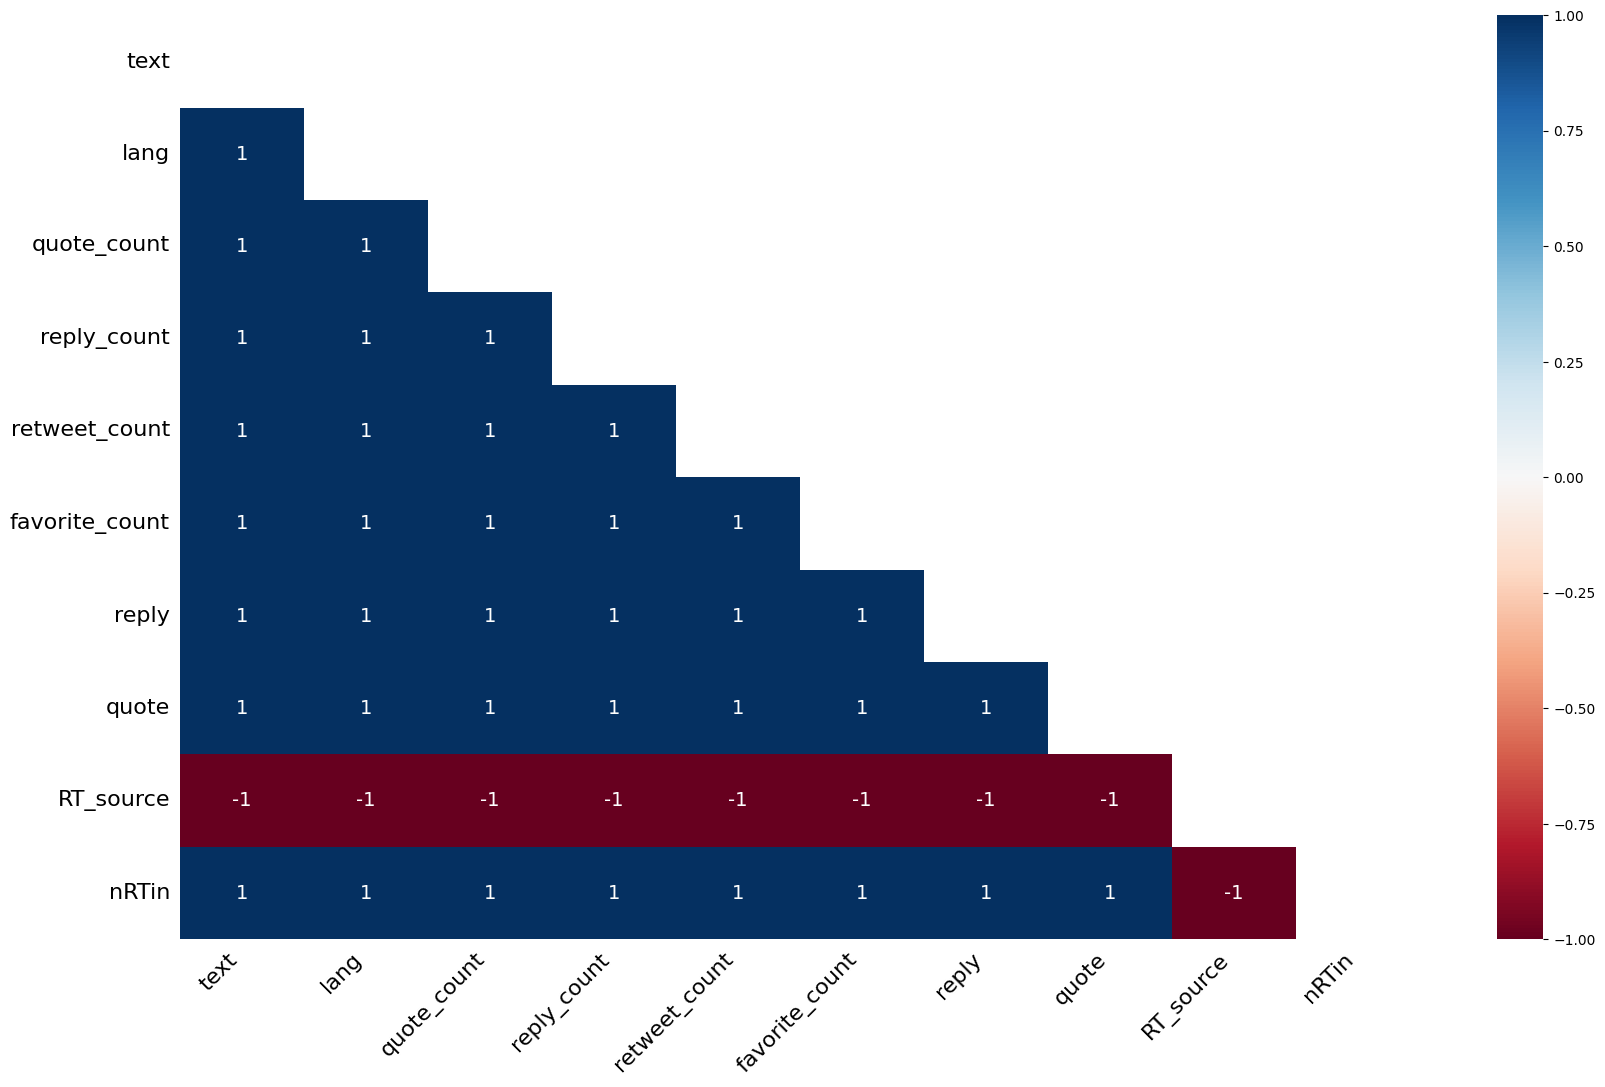

In [13]:
colnulos = ['text', 'lang', 'quote_count', 'reply_count', 'retweet_count',
       'favorite_count', 'reply', 'quote', 'RT_source', 'nRTin']
msno.heatmap(df2[colnulos])
# solución

¿Qué conclusión sacas? Una o dos frases deben bastar 

---

### **Ejercicio 5** 

Vamos a dividir `df2` en dos dataframes: `df_original` que solo tiene tweets que tengan `RT` a False, y `df_RT`que solo tenga filas que tengan `RT`a True.  Observar que es una partición del dataframe ya que RT no tiene nulos y solo toma los valores True y False

In [14]:
# solución

df_original=df2[df2['RT']==False]
df_RT=df2[df2['RT']==True]

In [15]:
# para probar
print(len(df2), len(df_RT)+len(df_original))
df_original.info()

8223 8223
<class 'pandas.DataFrame'>
Index: 4126 entries, 0 to 8222
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   _id             4126 non-null   str                
 1   text            4126 non-null   str                
 2   userid          4126 non-null   str                
 3   screen_name     4126 non-null   str                
 4   created_at      4126 non-null   datetime64[us, UTC]
 5   lang            4126 non-null   str                
 6   quote_count     4126 non-null   float64            
 7   reply_count     4126 non-null   float64            
 8   retweet_count   4126 non-null   float64            
 9   favorite_count  4126 non-null   float64            
 10  reply           4126 non-null   object             
 11  quote           4110 non-null   object             
 12  RT              4126 non-null   bool               
 13  RT_source       0 non-null      str    

In [16]:
# para probar
df_RT.info()

<class 'pandas.DataFrame'>
Index: 4097 entries, 2 to 7999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   _id             4097 non-null   str                
 1   text            0 non-null      str                
 2   userid          4097 non-null   str                
 3   screen_name     4097 non-null   str                
 4   created_at      4097 non-null   datetime64[us, UTC]
 5   lang            0 non-null      str                
 6   quote_count     0 non-null      float64            
 7   reply_count     0 non-null      float64            
 8   retweet_count   0 non-null      float64            
 9   favorite_count  0 non-null      float64            
 10  reply           0 non-null      object             
 11  quote           0 non-null      object             
 12  RT              4097 non-null   bool               
 13  RT_source       4097 non-null   str              

---
### **Ejercicio 6** 
Decidir a partir del resultado de las llamadas a info() (y del sentido común) qué columnas se pueden eliminar en cada caso. Eliminarlas dejando el resultado en el mismo dataframe.

Pista: Las columnas que tienen un valor único, tambien podrían borrarse 
Nota: 
- No borrar "_id", "userid" o "screen_name", vamos a utlizarlas más adelante
- se pueden escribir los nombres de las columnas explícitamente ("a mano"), pero entonces el apartado vale 0.25 en lugar de 1, es preferible programar el criterio que se haya elegido para su eliminación


In [17]:
df_RT.isna().all()
df_original.isna().all()

_id               False
text              False
userid            False
screen_name       False
created_at        False
lang              False
quote_count       False
reply_count       False
retweet_count     False
favorite_count    False
reply             False
quote             False
RT                False
RT_source          True
nRTin             False
dtype: bool

In [18]:
# solución
#df2 = df.drop(columns = ['coordinates'])
df_RT = df_RT.drop(columns = ['text', 'lang', 'quote_count', 'reply_count', 'retweet_count', 'favorite_count', 'reply', 'quote', 'nRTin'])
df_original = df_original.drop(columns = ['RT_source'])


In [19]:
# para probar
df_RT.head()

,_id,userid,screen_name,created_at,RT,RT_source
2,1318888111699599362,1290009888580657152,why_inn,2020-10-21 12:13:24+00:00,True,1318884437258571777
4,1313626566694404096,3285934814,Bill4TruthTrump,2020-10-06 23:45:54+00:00,True,1313617592125448194
5,1323494450883166208,897848315752071169,HamilBaltisar,2020-11-03 05:17:21+00:00,True,1323467682671415302
6,1312583721090867200,247903672,mike4libertyCA,2020-10-04 02:42:00+00:00,True,1312560078717943809
7,1315739228869808128,1288936715793571840,RichCrowe5,2020-10-12 19:40:52+00:00,True,1315736794982281224


In [20]:
# para probar
df_original.head()

,_id,text,userid,screen_name,created_at,lang,quote_count,reply_count,retweet_count,favorite_count,reply,quote,RT,nRTin
0,1322162444786126848,Winners attract other winners,289706821,thatguy0603,2020-10-30 13:04:26+00:00,en,0.0,0.0,0.0,0.0,False,True,False,0.0
1,1316829358686834688,NOW WE KNOW...C-SPAN Steve Sculley tried to ri...,1116507977828175872,FloridaDude297,2020-10-15 19:52:39+00:00,en,12.0,28.0,681.0,1232.0,False,False,False,0.0
3,1321483993922023424,@realDonaldTrump Vote Biden🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊,922851359594033152,Janet06969062,2020-10-28 16:08:30+00:00,fr,0.0,0.0,0.0,0.0,True,False,False,0.0
9,1313497108566011905,@realDonaldTrump https://t.co/uU7arNqAKK,941136678369968129,Trump_4Prison,2020-10-06 15:11:28+00:00,und,0.0,0.0,0.0,0.0,True,False,False,0.0
10,1314650690866741248,@Johnny_Congress @SugengHaryono70 @TeamTrump @...,940807712161587200,GjsgloBug,2020-10-09 19:35:24+00:00,en,0.0,0.0,0.0,0.0,True,False,False,0.0


---

### **Ejercicio 7**. 
(3 puntos) Queremos analizar los perfiles de las personas que escribieron los tuits, por lo que vamos a analizar varios aspectos.

a) Añade una nueva columna que represente la longitud de los tuits.

In [22]:
#solución
dflen= df.copy()
dflen['len_text'] = dflen['text'].str.len()
#para probar
dflen.head()

,_id,text,userid,screen_name,created_at,lang,quote_count,reply_count,retweet_count,favorite_count,coordinates,reply,quote,RT,RT_source,nRTin,len_text
0,1322162444786126848,Winners attract other winners,289706821,thatguy0603,2020-10-30 13:04:26+00:00,en,0.0,0.0,0.0,0.0,NaN,False,True,False,NaN,0.0,29.0
1,1316829358686834688,NOW WE KNOW...C-SPAN Steve Sculley tried to ri...,1116507977828175872,FloridaDude297,2020-10-15 19:52:39+00:00,en,12.0,28.0,681.0,1232.0,NaN,False,False,False,NaN,0.0,115.0
2,1318888111699599362,NaN,1290009888580657152,why_inn,2020-10-21 12:13:24+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1318884437258571777,NaN,NaN
3,1321483993922023424,@realDonaldTrump Vote Biden🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊,922851359594033152,Janet06969062,2020-10-28 16:08:30+00:00,fr,0.0,0.0,0.0,0.0,NaN,True,False,False,NaN,0.0,38.0
4,1313626566694404096,NaN,3285934814,Bill4TruthTrump,2020-10-06 23:45:54+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1313617592125448194,NaN,NaN


b) Cálculo de outliers de manera numérica de la variable que hace referencia a la longitud de texto. 

In [26]:
#solución
# Calcular IQR y límites para outliers
IRQ=dflen['len_text'].quantile(0.75)-dflen['len_text'].quantile(0.25)
lower_bound=max(dflen['len_text'].quantile(0.25)-1.5*IRQ,0)
upper_bound=dflen['len_text'].quantile(0.75)+1.5*IRQ
print("Punto minimo: ", lower_bound)
print("Punto maximo: ", upper_bound)

# Filtrar outliers bajos y altos por separado
low_outliers = dflen[dflen['len_text'] < lower_bound]
high_outliers = dflen[dflen['len_text'] > upper_bound]

# Mostrar resultados
print("Outliers bajos:",low_outliers.shape[0])


print("\nOutliers altos: ",high_outliers.shape[0])
print(high_outliers['len_text'])



Punto minimo:  0
Punto maximo:  361.5
Outliers bajos: 0

Outliers altos:  20
110     677.0
196     705.0
1059    393.0
1190    392.0
1806    380.0
2274    415.0
3052    714.0
3702    376.0
3804    598.0
4060    370.0
4594    367.0
4731    757.0
4805    401.0
6084    371.0
6202    413.0
6514    374.0
7293    369.0
7338    366.0
7813    396.0
8053    767.0
Name: len_text, dtype: float64


c) Dibuja un histograma para visualizar la distribucion de los textos

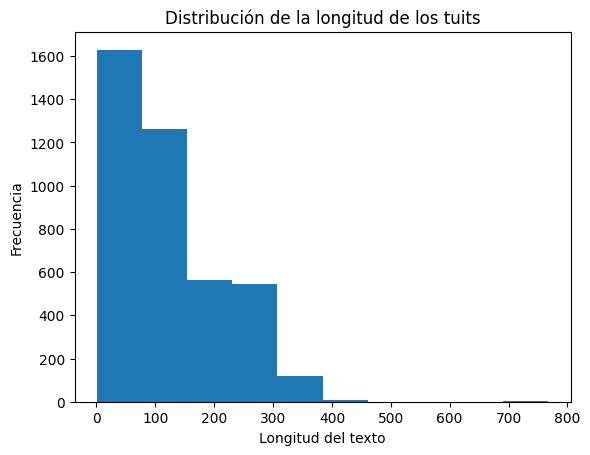

In [29]:
import matplotlib.pyplot as plt

#solución
plt.hist(dflen['len_text'])
plt.xlabel('Longitud del texto')
plt.ylabel('Frecuencia')
plt.title('Distribución de la longitud de los tuits')
plt.show()

La distribución es un poco extraña ... ¿Hay tuits vacios? ¿Qué ocurre?

In [ ]:
#Si, gran parte de los tuits tienen longitud nula y la mayoria no llega a penas a 200 aunque hay algunos que superan los 1600 caracteres

d) Dibuja boxplots para visualizar los posibles outliers 

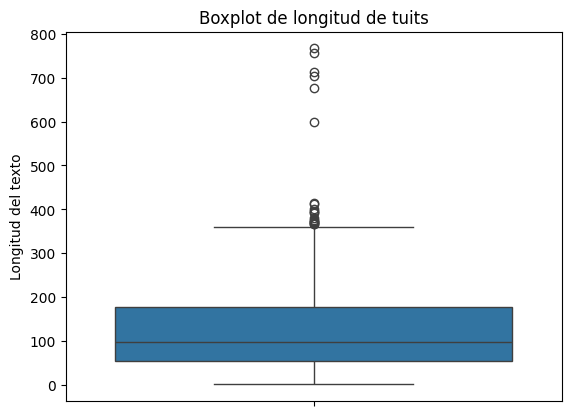

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

#solución
sns.boxplot(data=dflen, y='len_text')
plt.title('Boxplot de longitud de tuits')
plt.ylabel('Longitud del texto')
plt.show()


Ahora, muestra los outliers por idioma

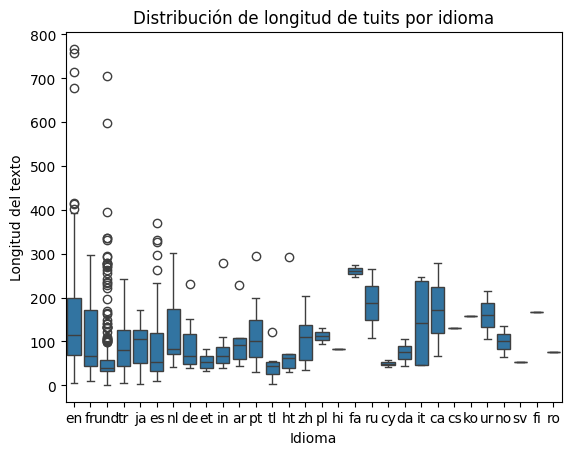

In [38]:
#solución
sns.boxplot(data=dflen, x='lang', y='len_text')
plt.title('Distribución de longitud de tuits por idioma')
plt.xlabel('Idioma')
plt.ylabel('Longitud del texto')
plt.show()

Vemos que algunos de los idiomas no son especialmente representativos. Quizá deberíamos hacer algo con ello, pero antes ... 

e) Filtra los outliers

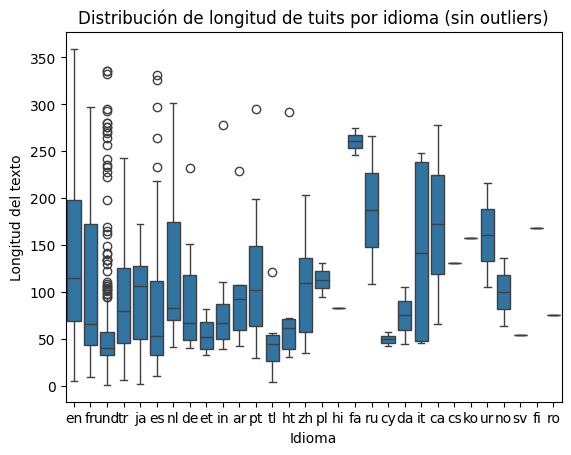

In [39]:
#solución
dflen_sin_outliers = dflen[(dflen['len_text'] >= lower_bound) & (dflen['len_text'] <= upper_bound)]
sns.boxplot(data=dflen_sin_outliers, x='lang', y='len_text')
plt.title('Distribución de longitud de tuits por idioma (sin outliers)')
plt.xlabel('Idioma')
plt.ylabel('Longitud del texto')
plt.show()

No te alarmes, los outliers son efecto visual y reajuste de pesos, está bien.

---
### **Ejercicio 8** 

Queremos eliminar de `df_original` las filas que corresponan a lenguajes que aparezcan menos de 10 veces en este dataframe. Dejar el resultado `df_original_lang`

Ayuda: 

- El método df.c.value_counts() devuelve un valor de tipo Series donde el índice (index) es el cada valor distinto de c, ordenado de más a menos frecuente, y el valor es dicha frecuencia
- El método df.c.isin(l) devuelve True para aquellos valores de c que estén en la lista l, y False en caso contrario

In [56]:
# solución
serie = df_original.lang.value_counts()
lista=serie[serie>=10].index.tolist()
a = df_original.lang.isin(lista)
lista2=a[a==False].index.tolist()
df_original_lang=df_original.drop(lista2)
# para probar
df_original_lang.lang.value_counts()

lang
en     3336
und     610
es       43
fr       26
pt       20
Name: count, dtype: int64